# The following is heavily inspired by Anas' work as it served as a basis and an introduction to pyTorch (coming from Tensorflow)

Libraries import

In [141]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# DFA Model

In [142]:
class SimpleDFA(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, hidden_layers_number=1):
        
        super(SimpleDFA, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layers_number = hidden_layers_number
        self.output_size = output_size
        
        # Use ModuleList for layers
        self.layers = nn.ModuleList(
            [nn.Linear(input_size, hidden_size)] + 
            [nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers_number)] + 
            [nn.Linear(hidden_size, output_size)]
        )
        
        self.activation = nn.Tanh()  # Use Tanh activation function

    def forward(self, x):
        # Apply activation to each hidden layer
        for layer in self.layers[:-1]:  # All except the last layer
            x = self.activation(layer(x))
        # Final layer (output layer) without activation
        x = self.layers[-1](x)
        return x
    
    
    def Init_weights(self):
        # Xavier init on weights
        for layer in self.layers: 
            nn.init.xavier_uniform_(layer.weight) 

    
    def Init_feedback(self):
        # Create feedback matrices matching each layer's output size
        self.B_hiddens = [torch.randn(self.hidden_size, self.output_size) * 0.01 for _ in range(self.hidden_layers_number)]
        self.B_output = torch.randn(self.output_size, self.output_size) * 0.01  # Feedback for output layer

        # Normalize feedback matrices
        for i in range(len(self.B_hiddens)):
            self.B_hiddens[i] /= self.B_hiddens[i].norm()
        self.B_output /= self.B_output.norm()

        return self.B_hiddens + [self.B_output]  # Feedback matrices for hidden layers + output


    def forward_pass(self,Input,Target,loss_func):
        
        # Forward pass
        Output = self.forward(Input)
        loss = loss_func(Output, Target)
        return Output, loss
        
    def activation_derivative(self, x):
        
        return 1 - self.activation(x)**2  # Derivative of Tanh activation function
    

# DFA training step (UPDATING IN PROGRESS)

check what's up with hidden_activations

In [143]:
def dfa_update_step(model, Bs, output, target, hidden_activations, inputs, learning_rate=0.01):
    # Compute error at the output
    error = output - target  # Compute error at the output layer

    # Update the output layer first
    feedback_signal_output = error * model.activation_derivative(output)
    with torch.no_grad():
        # Update output layer weights and biases
        delta_w_out = torch.matmul(feedback_signal_output.T, hidden_activations[-1])
        model.layers[-1].weight -= learning_rate * delta_w_out
        delta_b_out = feedback_signal_output.sum(0)
        model.layers[-1].bias -= learning_rate * delta_b_out

    # Now, propagate backward through the hidden layers
    for index in reversed(range(len(model.layers) - 1)):  # Hidden layers (in reverse order)
        # Compute feedback signal for hidden layers
        feedback_signal_hidden = torch.matmul(feedback_signal_output, Bs[index]) * model.activation_derivative(hidden_activations[index])

        with torch.no_grad():
            # Update weights and biases for hidden layers
            delta_w = torch.matmul(feedback_signal_hidden.T, hidden_activations[index - 1] if index > 0 else inputs)
            model.layers[index].weight -= learning_rate * delta_w
            delta_b = feedback_signal_hidden.sum(0)
            model.layers[index].bias -= learning_rate * delta_b

            # Prepare feedback signal for the next (previous) layer
            feedback_signal_output = feedback_signal_hidden



# Test stuff

In [144]:
def train(model, data, targets, loss_fn, learning_rate=0.01, epochs=1000):
    # Initialize feedback matrices
    Bs = model.Init_feedback()

    losses = []  # To store the loss at each epoch
    for epoch in range(epochs):
        # Forward pass

        # Pass data through each hidden layer and store activations
        hidden_activations = []
        x = data
        for layer in model.layers[:-1]:  # Collect activations for hidden layers only
            x = model.activation(layer(x))
            hidden_activations.append(x)

        output, loss = model.forward_pass(data, targets, loss_fn)

        # Apply DFA update step
        dfa_update_step(model, Bs, output, targets, hidden_activations, data, learning_rate)

        # Store the loss
        losses.append(loss.item())

        # Print loss and accuracy every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item()}")

            # Compute accuracy
            predictions = (output >= 0.5).float()  # Threshold the output to get binary predictions
            correct = (predictions == targets).float().sum()
            accuracy = correct / targets.size(0)
            print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Plot the convergence of loss
    plt.plot(losses)
    plt.title("Convergence of Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


Epoch [0/1000], Loss: 0.6948074102401733
Accuracy: 50.00%
Epoch [100/1000], Loss: 0.18433186411857605
Accuracy: 100.00%
Epoch [200/1000], Loss: 0.02630317024886608
Accuracy: 100.00%
Epoch [300/1000], Loss: 0.004430525936186314
Accuracy: 100.00%
Epoch [400/1000], Loss: 0.0008657918078824878
Accuracy: 100.00%
Epoch [500/1000], Loss: 0.0035880575887858868
Accuracy: 100.00%
Epoch [600/1000], Loss: 0.002349691931158304
Accuracy: 100.00%
Epoch [700/1000], Loss: 5.876858631381765e-05
Accuracy: 100.00%
Epoch [800/1000], Loss: 1.6137704506036243e-06
Accuracy: 100.00%
Epoch [900/1000], Loss: 7.286570280484739e-08
Accuracy: 100.00%


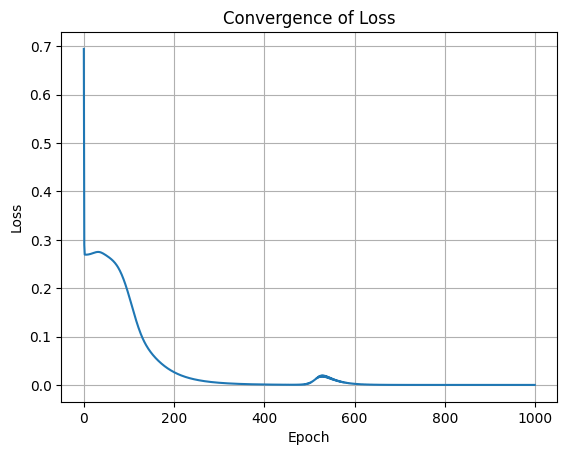

In [145]:
# Example usage with XOR data
input_size = 2  # XOR has two input features (0 or 1)
hidden_size = 4  # Hidden layers size
hidden_layers_number = 1 # Number of hidden layers
output_size = 1  # XOR has one output feature (0 or 1)
# Define XOR inputs and targets
data = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)  # XOR inputs
targets = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)  # XOR targets

# Initialize the model and loss function
model = SimpleDFA(input_size, hidden_size, output_size, hidden_layers_number)
model.Init_weights()  # Initialize the weights

loss_fn = nn.MSELoss()

# Train the network using DFA and print XOR accuracy
train(model, data, targets, loss_fn, learning_rate=0.1, epochs=1000)